<a href="https://colab.research.google.com/github/Bouncy0Knight/Exercise6/blob/main/CompModNervSys_exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System 
# Exercise 6: Simulating the Hodgkin-Huxley model in NEURON

### Exercise goals

1) Learn how to simulate the Hodgkin-Huxley model of the squid giant axon action potential in NEURON

2) Understand the time course of the action potential

3) Conduct voltage clamp experiments to isolate and analyze the sodium and potassium membrane currents


Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with ***Q:*** preceding them, write your responses in text cells. 


In [1]:
!git clone https://github.com/CompModNervSystem/CompModNervSys-HH1.git # downloads repository into our Google colab session's file system

Cloning into 'CompModNervSys-HH1'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (9/9), 55.77 KiB | 2.23 MiB/s, done.


We'll first install neuron like last time

In [2]:
%pip install neuron # only need to run this cell once to install 
                    # neuron in the local jupyter environment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 14.9 MB/s eta 0:00:00


Import the packages we'll be using

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary 

import numpy as np

## Simulating the squid giant axon action potential

Let's start replicating the setup of the Nobel-prize winning experiments by Alan Hodgkin and Andrew Huxley

We'll follow the modeling steps outlined in Lecture 5:

1) Import necessary libraries (already done!)

2) Specify model topology

3) Specify model geometry

4) Specify biophysical properties

5) Specify stimulation and recording instrumentation

6) Specify simulation settings (time step, duration, initialization conditions)

We'll be modeling the isolated squid giant axon preparation, which consisted of a single axon with diameter big enough to stick an intracellular electrode into. 

Completing steps 2 and 3, fill in the code below creating a NEURON *section* for the axon and assigning its geometrical parameters with a diameter of $500 \; \mu m$ and length of $100 \; \mu m$ (assume this is a short stretch of axon). We'll use a single segment to discretize this section by setting $nseg$ to 1. And since we're just modeling a single isolated axon, we don't have to worry about connecting to any other sections (e.g., the soma) or other neurons.

In [4]:
axon = h.Section(name='axon')

axon.diam =  500# diameter in microns
axon.L =  100# length in microns

axon.nseg = 1 # sets number of segments to 1


<span style="color:red"> 
<b><i>Q1:</b></i> What aspect of Hodgkin and Huxley's experiments allows us to set the number of segments (nseg) to 1?
</span>

The H-H model assumed that the entire giant squid axon was a uniform cable with homogenous properties. The voltage clamp set the voltage of the entire cable to the same level. 

Next, we'll assign the biophysical properties to the axon (4). Luckily, NEURON comes built in with a membrane mechanism representing the Hodgkin and Huxley model exactly. For now we'll treat it as an experimental preparation in which we don't have access to any variables Hodgkin and Huxley didn't access to in their experiments.

So, we simply `insert` the density mechanism for the HH model, called `hh` in NEURON:

In [5]:
axon.insert('hh')

axon.psection() # check that it's inserted

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.0003],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'minf': [0.0],
   'hinf': [0.0],
   'ninf': [0.0],
   'mtau': [0.0],
   'htau': [0.0],
   'ntau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'axon',
 'hoc_internal_name': '__nrnsec_0x36c1a10',
 'cell': None}

From running `psection()`, you can see there are some terms in the `density_mechs` dictionary now. Again, for now, we'll imagine we can't just ask our computational model what these variables are. 

Now, we need to set up our recording and stimulation instrumentation (5).

Let's first measure an action potential in our model axon preparation, just like Hodgkin and Huxley did in the first of their series of 5 papers published in 1952. We'll use a "current clamp", like in last exercise, to inject a current pulse and measure voltage. We'll create it in the cell below and assign parameters later.

In [6]:
iclamp = h.IClamp(axon(0.5)) # add current clamp to the middle of our secion (x=0.5)

# Set up recordings
# Each vector is created as a NEURON Vector object (h.Vector) on the right hand side
# and saved as a python object (left hand side)
t = h.Vector() # time vector
t.record(h._ref_t)
V = h.Vector() # intracellular voltage (same as membrane potential in our case)
V.record(axon(0.5)._ref_v)
Ic = h.Vector()
Ic.record(iclamp._ref_i)


Vector[5]

Run the cell below to instantiate the `run_and_plot_Iclamp_sim` function, which calls `h.run()` to run the simulation and plots the membrane voltage and current clamp current

In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def run_and_plot_Iclamp_sim(t,v,ic):
    h.run()
    t = t.to_python(np.zeros(len(t)))  # convert to numpy arrays (not actually necessary for plotting)
    v = v.to_python(np.zeros(len(v)))
    ic = ic.to_python(np.zeros(len(ic)))    
    # Plot results
    fig = make_subplots(rows=2,cols=1)    
    # voltage
    fig.add_trace(go.Scatter(x=t,y=v,showlegend=False),row=1,col=1)
    fig['layout']['yaxis']['title']='Vm (mV)'
    # Current
    fig.add_trace(go.Scatter(x=t,y=ic,showlegend=False),row=2,col=1)    
    fig['layout']['xaxis2']['title']='time (ms)'        
    fig['layout']['yaxis2']['title']='Ic (nA)'
    fig.show()
    # Matplotlib implementation
    # fig = plt.figure()
    # ax = fig.add_subplot(211)
    # ax.plot(t,v)
    # ax.set_ylabel('V (mV)')
    # ax = fig.add_subplot(212)
    # ax.plot(t,ic)
    # ax.set_xlabel('time (ms)')
    # ax.set_ylabel('Ic (nA)')

<span style="color:red"> 
<b><i>Q2:</b></i>Why did we use a current clamp instead of a voltage clamp to measure the action potential?
</span>

A voltage clamp sets the Voltage to a certain level -- there's not much we can do to study action potentials with that. By using a current clamp, we can vary the current to figure out what the threshold for an action potential is and find the resistance of the cell to current. You can't really measure the action potential if the Voltage is constant. 

And for our last step (6), we need to choose our simulation settings. Set the time step to $0.0125 \; ms$, duration to $10 ms$, and initial voltage to $-62 \; mV$. Another setting we didn't worry about last time was the temperature, but as good biophysicists and experimentalists, Hodgkin and Huxley made sure to keep careful record of the temperature in their experiments, as it was already known that several aspects of the membrane potential and ion currents were temperature sensitive. Use a temperature of $6.3^{\circ} \; C$.

<span style="color:red"> 
<b><i>Q3:</b></i>What aspects of the membrane potential, either that we've covered already or that you would speculate, might be temperature sensitive?
</span>

Resistance may be temperature sensitive. At higher temps there is more random particle movement, and ions will travel across the membrane more easily. At lower temps, there will be a higher Resistance because ions will have more difficulty crossing the membrane. 

Now try running the simulation, first with the current clamp amplitude set to 0. Then, use the steady state voltage you observe from the plot to choose an initial voltage close to the resting potential of the axon and set the current clamp to deliver a $50 \; nA$ pulse with a $2 \; ms$ duration at $5 \; ms$. 

In [8]:
# Fill in the code below

iclamp.delay =  5# ms - delay of current clamp
iclamp.dur =  2# ms - duration of current clamp stimulus
iclamp.amp =  50# nA

h.v_init = -62 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation
h.tstop =  30 # ms - simulation duration


run_and_plot_Iclamp_sim(t,V,Ic)


Congratulations, you've just simulated an action potential!

## Voltage clamp experiments

So we've established our axon can generate an action potential. Unlike our previous model, we see both a subthreshold *passive* depolarization AND an *active* change in voltage, meaning it deviates from the voltage we'd expected from Ohm's law ($V = IR$) using the current we inject as $I$ and the membrane resistance as $R$. It also persists after the current ends, so some active process is causing this change in membrane potential that goes past $0 \; mV$. 

Let's follow in the footsteps of Hodgkin and Huxley and see how changing the voltage alters the ionic currents across the membrane.

NEURON has a built in model of a two electrode voltage clamp (which is what HH used), but we'll use the implementation of a more modern single electrode voltage clamp to make things easier (`SEClamp`). 

This voltage clamp will "clamp" the voltage, allowing the membrane current to evolve as it wants to. To measure the membrane current, we'll use a similar approach to HH, which is to measure the current applied by our negative feedback system to maintain the desired clamp voltage, which is equal to the membrane current. 

`SEClamp` has several settings that allow us to set the amplitude and duration of multiple *steps* in voltage:
- dur1, dur2, and dur3 in ms: duration of each voltage step
- amp1, amp2, and amp3 in mV: amplitude of each voltage step
- rs in MOhm : series resistance of recording electrode (don't worry about this one)
- vc in mV: variable tracking the clamp voltage at each point in time
- i in nA: variable tracking the current the voltage clamp is applying at each point in time

This information can be found in the [documentation]( https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#SEClamp) 

Set the voltage clamp parameters to generate the following set of voltage steps:
1. 2 ms at -65 mV
2. 5 ms at 0 mV
3. 5 ms at -65 mV


In [9]:
# Reset out model
from neuron import h
# Create axon
axon = h.Section(name='axon')
# Set morphology/discretization
axon.diam = 500 # diameter in microns
axon.L = 100 # length in microns
axon.nseg = 1 # sets number of segments to 1
# Set biophysics
axon.insert('hh')

# Set up instrumentation
# Voltage Clamp
vclamp = h.SEClamp(axon(0.5)) # add voltage clamp to the middle of our secion (x=0.5)
vclamp.dur1 = 2# ms - duration of initial clamp voltage
vclamp.amp1 =  -65# mV - initial clamp voltage
vclamp.dur2 =  5# ms - duration of second clamp voltage
vclamp.amp2 =  0# mV - second clamp voltage
vclamp.dur3 =  5# ms - duration of final clamp voltage
vclamp.amp3 = -65# ms - amplitude of final clamp voltage (return to start)
vclamp.rs = 1e-3
# Set up recordings
# Each vector is created as a NEURON Vector object (h.Vector) on the right hand side
# and saved as a python object (left hand side)
#t = h.Vector() # time vector
#t.record(h._ref_t)
V = h.Vector() # intracellular voltage (same as membrane potential in our case)
V.record(axon(0.5)._ref_v)
I = h.Vector() # voltage clamp current (equal to membrane current)
I.record(vclamp._ref_i)
Vc = h.Vector()
Vc.record(vclamp._ref_vc)




Vector[8]

Run the code below to instantiate a function for plotting a single voltage clamp experiment

In [10]:
def run_and_plot_Vclamp_sim1(t,v,i,vc,axon):
    # t - time Vector (NEURON object) (ms)
    # v - voltage Vector (mV)
    # i - current Vector (nA)
    # vc - voltage clamp vector (mV)
    # axon - NEURON Section of our axon model
    # Run single voltage clamp simulation and plot
    h.run()
    t = t.to_python(np.zeros(len(t)))  # convert to numpy arrays (not actually necessary for plotting)
    v = v.to_python(np.zeros(len(v)))
    i = 1e-6*i.to_python(np.zeros(len(i)))/(axon(0.5).area()*1e-8) # converts to current density in mA/cm2        
    # Plot results
    fig = make_subplots(rows=3,cols=1)    
    # voltage
    fig.add_trace(go.Scatter(x=t,y=v),row=1,col=1)     
    fig['layout']['yaxis']['title']='Vm (mV)'
    fig.update_layout(yaxis = dict(range=[-80,50]))
    # Current injected (converted to membrane current density)
    fig.add_trace(go.Scatter(x=t,y=i),row=2,col=1)    
    fig['layout']['yaxis2']['title']='Current density (mA/cm2)'    
    # Clamp voltage
    fig.add_trace(go.Scatter(x=t,y=vc),row=3,col=1) 
    fig['layout']['yaxis3']['title']='Vc (mV)'
    fig['layout']['yaxis3']['title']='Vm (mV)'
    fig['layout']['xaxis3']['title']='time (ms)'        
    fig.show()

    # Matplotlib implementation
    # fig = plt.figure()
    # ax = fig.add_subplot(311)
    # ax.plot(t,v)    
    # ax.set_ylabel('V (mV)')
    # ax.set_ylim(-80,40)
    # ax = fig.add_subplot(312)
    # ax.plot(t,i)
    # ax.set_xlabel('time (ms)')
    # ax.set_ylabel('Current density (mA/cm2)')
    # ax = fig.add_subplot(313)
    # ax.plot(t,vc)
    # ax.set_xlabel('time (ms)')
    # ax.set_ylabel('Vc (mV)')
    # ax.set_ylim(-80,40)


In [11]:
h.v_init = vclamp.amp1 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation, set to room temperature
# choose a tstop
h.tstop =  200# ms - simulation duration
run_and_plot_Vclamp_sim1(t,V,I,Vc,axon)


Now, let's recreate the figure below from the end of the first Hodgkin Huxley paper (Fig. 12). Each line corresponds to the membrane current caused by clamping the voltage to the adjacent number.

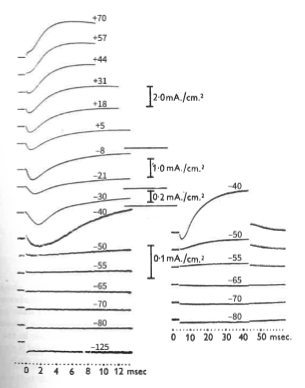

In [12]:
from IPython.display import Image

Image('CompModNervSys-HH1/resources/HH1952a_Fig12.png',width=250)

We'll need a function that can loop through a set of voltage clamp amplitudes and plot the results. The functions below accomplish just that.

In [13]:
def run_Vclamp_sims(axon,vclamp,v_steps,dt=0.0125,celsius=6.3):
    # Run set of voltage clamp simulation and plot
    # Set up recordings
    # Each vector is created as a NEURON Vector object (h.Vector) on the right hand side
    # and saved as a python object (left hand side)
    t = h.Vector() # time vector
    t.record(h._ref_t)
    V = h.Vector() # intracellular voltage (same as membrane potential in our case)
    V.record(axon(0.5)._ref_v)
    I = h.Vector() # voltage clamp current (equal to membrane current)
    I.record(vclamp._ref_i)
    Vc = h.Vector()
    Vc.record(vclamp._ref_vc)
    A = axon(0.5).area()*1e-8 # area in cm2
    # simulation settings
    h.dt = dt
    h.celsius = celsius
    h.tstop = vclamp.dur1+vclamp.dur2
    V_all = []
    I_all = []
    Vc_all = []    
    for v_step in v_steps:
        h.v_init = vclamp.amp1
        vclamp.amp2 = v_step 
        h.run()
        V_all.append(V.to_python(np.zeros(len(V))))
        I_all.append(1e-6*I.to_python(np.zeros(len(I)))/A) # convert to current density in mA/cm2
        Vc_all.append(Vc.to_python(np.zeros(len(Vc))))            
    
    return I_all, V_all, Vc_all, t

def plot_Vclamp_sims(t, I_all,V_all,v_steps,title=None,yaxis_label='I (mA/cm2)'):
     # Plot results
    fig = make_subplots(rows=2,cols=1)        
    for I,V,v_step in zip(I_all,V_all,v_steps):        
        # Current injected (converted to membrane current density)
        fig.add_trace(go.Scatter(x=t,y=I,showlegend=False,name='{:.1f} mV'.format(v_step)),row=1,col=1)    
        fig['layout']['yaxis']['title']=yaxis_label    
        # voltage achieved by our clamp (no need to plot desired clamp voltage, we know it's working)
        fig.add_trace(go.Scatter(x=t,y=V,showlegend=True,name='{:.1f} mV'.format(v_step)),row=2,col=1)     
        fig['layout']['yaxis2']['title']='V (mV)'
        fig['layout']['xaxis2']['title']='time (ms)'   
        fig.update_layout(yaxis2 = dict(range=[-110,60]))    
        if title is not None:
            fig.update_layout(title=title)    
             
    fig.show()

Now let's run a voltage clamp experiment with voltages between $-100 \; mV$ and $+40 \; mV$, using the same timing scheme as above. Choose as many steps as you'd like.

In [14]:
# Reinitialize Voltage Clamp
vclamp = h.SEClamp(axon(0.5)) # add voltage clamp to the middle of our secion (x=0.5)
vclamp.dur1 = 2 # ms - duration of initial clamp voltage
vclamp.amp1 =  -65# mV - initial clamp voltage
vclamp.dur2 =  5# ms - duration of second clamp voltage
vclamp.amp2 =  -60# mV - second clamp voltage
vclamp.dur3 =  5# ms - duration of final clamp voltage
vclamp.amp1 =  -70# ms - amplitude of final clamp voltage (return to start)
vclamp.rs = 1e-3

v_steps =  np.arange(-100,40,40)# your code goes here, make array/list of voltage steps

I_all, V_all, Vc_all, t = run_Vclamp_sims(axon,vclamp,v_steps)

plot_Vclamp_sims(t, I_all,V_all,v_steps)

<span style="color:red"> 
<b><i>Q3:</b></i> What happens to the inward current as the voltage steps go to higher and higher positive potentials? Use the interactive plot to get a closer look at the different current traces.
</span>

As the voltage becomes more positive, the inward current increases too. 

Hodgkin and Huxley made the clever observation that if the inward current is mediated by sodium ions, they should be able to not only predict its reversal potential, but also predict how changes in the extracellular sodium concentration should alter it. They did this by realizing they can rearrange the Nernst equation for before and after they change the extracellular sodium concentration to be expressed purely in terms they can experimentally measure and control. Based on the assumption that the total current $I$ was just the sum of the potassium $I_{K}$ and hypothetical sodium current $I_{Na}$, they were able to calculate these separate currents.

NEURON doesn't represent the ion concentrations explicitly for the `hh` model; instead the reversal potentials are set directly. Try lowering $E_{Na}$ from its default value (+50 mV) to -5 mV and run the same set of voltage clamp sweeps. 

In [15]:
axon(0.5).ena = 50 # start at default value

I_all, V_all, Vc_all, t = run_Vclamp_sims(axon,vclamp,v_steps)

plot_Vclamp_sims(t, I_all,V_all,v_steps)

# Your code goes here

# lower ena, run simulations and plot
axon(0.5).ena = 10 #mV

I_all, V_all, Vc_all, t = run_Vclamp_sims(axon,vclamp,v_steps)

plot_Vclamp_sims(t, I_all,V_all,v_steps)



axon(0.5).ena = 50 # reset it for later experiments below





<span style="color:red"> 
<b><i>Q4:</b></i> What happened to the inward current when you changed the sodium reversal potential? IT DECREASES.
</span>

They also did experiments in which the sodium in the extracullar solution (which was seawater) was replaced entirely with a different cation called choline. They found there was no inward current in choline, not only providing further support for the idea that the inward current was sodium, but also allowing them to calculate the sodium current. We can replicate this experiment by setting the sodium conductance in our model to zero (something they couldn't do at the time). Modern studies of cellular excitability use drugs that can selectively block ion channel conductances, but these hadn't been discovered yet. 

The name of the parameter for the HH model's peak sodium conductance in NEURON is `gnabar_hh`. Lower it to zero, repeat your voltage clamp experiment and plot. Similar to Hodgkin and Huxley, compute the sodium current by subtracting the currents in the "choline" condition from the normal currents and plot using the same plotting function. 

In [16]:
axon(0.5).gnabar_hh = 0.12

I_all, V_all, Vc_all, t = run_Vclamp_sims(axon,vclamp,v_steps,)

plot_Vclamp_sims(t, I_all,V_all,v_steps,title='I total')

# Simualte lowering extracellular by setting gnabar_hh to 0
axon(0.5).gnabar_hh = 0 # lowered extracellular Na

# Generate list of current vectors I_all2 using run_Vclamp_sims
# Your code goes here
I_all2,V_all2,Vc_all2,t2 = run_Vclamp_sims(axon,vclamp,v_steps,)

# Use list comprehension to subtract recordings at each voltage with and without sodium current 
Ina_est = [I1 - I2 for I1,I2 in zip(I_all,I_all2)]

plot_Vclamp_sims(t, Ina_est,Vc_all,v_steps,title='Ina')

Ik_est = [I1 - I2 for I1,I2 in zip(I_all,Ina_est)]

plot_Vclamp_sims(t, Ik_est,Vc_all,v_steps,title='Ik')

axon(0.5).gnabar_hh = 0.12 # reset it for later experiments

<span style="color:red"> 
<b><i>Q5:</b></i> Describe the putative sodium and potassium currents we isolated. How do they change in magnitude and direction with voltage? As voltage gets more positive, both increase in magnitude. The sodium current becomes more negative, and the potassium current becomes more positive.
</span>

Below, try writing code similar to the code above to subtract the sodium and potassium current from the total current. 

<span style="color:red"> 
<b><i>Q6:</b></i> Is there any current remaining in these traces? Why or why not? Yes; we've taken out the current from Sodium and Potassium which gives us 0. Technically, though, in a real cell, there should still be other current sources, even though they're really small. </span>

In [17]:
I_rem = [I1 - I2 - I3 for I1,I2,I3 in zip(I_all,Ina_est,Ik_est)]

plot_Vclamp_sims(t, I_rem,Vc_all,v_steps,title='I - Ina - Ik')

So far, we've visualized ionic currents, but to build up to their biophysical model, Hodgkin and Huxley converted these currents to conductance. To do this, they used the driving force equation we introduced in class as part of the parallel conductance model:

$ I_{ion} = g_{ion}(V - E_{ion}) $. 

Except now, the conductance $g_{ion}$ can change with time! Doing some algebra and plugging in our ions of interest, Na and K, this gives us:

$ g_{Na} =  I_{Na}/(V - E_{Na}) $
$ g_{K} = I_{K}/(V - E_{K}) $. 

This was a novel idea at the time, as researchers were still talking about ion fluxes in terms of *permeability*, not conductance. They didn't have access to the intracellular ion concentrations, which is normally needed to compute the Nernst potentials, $E_{Na}$ and $E_{K}$, so they used an empirical method of measuring them: finding the voltage at which the currents "reversed" or became zero. 


Below, compute the sodium and potassium *conductances* using the equations above and the reversal potential parameters incorporated in the model. Plot with the same function used above. (Remember, to get $E_{Na}$ we used `axon(0.5).ena`)

<span style="color:red"> 
<b><i>Bonus question:</b></i> Write code to extract the reversal potential from the sodium and potassium current traces generated above. 
</span>

In [18]:
Ena = axon(0.5).ena
Ek = axon(0.5).ek

# loop through each current in the lists to compute the conductances below
gNa_all = []
gK_all = []
for Ii, Vi in zip(Ina_est,V_all):
    gNa = Ii/(Vi-Ena)
    gNa_all.append(gNa)

for Ii,Vi in zip(Ik_est,V_all):
    gK = Ii*(Vi-Ek)
    gK_all.append(gK)
    
plot_Vclamp_sims(t, gNa_all,V_all,v_steps,title='gNa',yaxis_label='gNa (S/cm2)')

plot_Vclamp_sims(t, gK_all,V_all,v_steps,title='gK',yaxis_label='gK (S/cm2)')

<span style="color:red"> 
<b><i>Q7:</b></i> What key differences do you observe between the estimated sodium and potassium condutances? How are they similar? Sodium conductances peak quickly and then level off over a longer period of time. Potassium conductances slowly rise over a long period and then fall back to rest over a long period. </span>

This takes us through the end of the second of their five seminal papers. We measured the action potential of the squid giant axon, and then we used the voltage clamp technique to measure the membrane currents as a function of fixed voltages. Using similar experimental manipulations to Hodgkin and Huxley, we isolated the sodium and potassium currents *and* conductances. Hodgkin and Huxley presented further evidence that these conductances are *voltage-dependent*, which was a critical discovery on the path to discoverying voltage-gated ion channels, the electrical basis of the nervous system, and biophysical models of the brain. Next exercise, we'll look at how these conductances vary with voltage and how their model predicted the existence AND behavior of voltage-gated ion channels before they'd been discovered